In [1]:
import numpy as np
import os
import pandas as pd
import copy
import matplotlib.pyplot as plt   
import seaborn as sns
import psycopg2
import pickle
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")

In [2]:
connection = psycopg2.connect(database="edw_dev", user="postgres", password="AocAvalonPG123", host="52.15.157.95",port=5432)
cursor = connection.cursor()

In [3]:
data1 = pd.read_sql_query('select edw_fact.mme_details."procedure date",edw_src.patient_info.gender,edw_fact.mme_details.master_procedure,edw_fact.mme_details.patient_type,edw_fact.mme_details.physician_name,edw_fact.mme_details.age,edw_fact.mme_details.bmi,edw_fact.mme_details.mme_medication_administrated_perdayavg from edw_fact.mme_details full outer join edw_src.patient_info on edw_fact.mme_details.unique_opd_id = edw_src.patient_info.procedure_id;',con=connection)
data1 = data1.replace('INPATIENT','IN-PATIENT')
data1.head()

,procedure date,gender,master_procedure,patient_type,physician_name,age,bmi,mme_medication_administrated_perdayavg
0,2018-02-08,M,ARTHROSCOPY,OUT PATIENT,"WOLF, BRIAN R",41,36.44,12.00
1,2018-04-10,F,ARTHROSCOPY SHOULDER,IN-PATIENT,"PATTERSON, BRENDAN M",69,37.51,45.00
2,2018-07-31,M,ARTHROSCOPY,OUT PATIENT,"BOLLIER, MATTHEW J",63,38.02,30.34
3,2019-12-31,M,ARTHROPLASTY,OUT PATIENT,"NOISEUX, NICOLAS O",65,31.68,53.83
4,2019-12-03,M,ARTHROSCOPY SHOULDER,OUT PATIENT,"BOLLIER, MATTHEW J",61,24.91,30.00


In [4]:
data1 =  data1.dropna()
data1 = data1.drop_duplicates()
data1.shape

(11472, 8)

In [5]:
a = list(data1[data1['bmi'] > 50].index)
data1 = data1.drop(a)
data1.shape

(11269, 8)

In [6]:
def data_year(data,doctor,yearr,patient_type):
    
    A = data[data['physician_name'] == doctor]
    A = A[A['patient_type'] == patient_type]
    A['procedure date'] = pd.to_datetime(A['procedure date'])
    
    year = []
    month = []
    for i in A['procedure date']:
        a = i.year
        b = i.month
        year.append(a)
        month.append(b)
    A['Year'] = year
    A['Month'] = month
    
    B = A[A['Year'] == yearr]
    
    lowwer = []
    higher = []
    mediumm = []
    Month = []
    for i in list(range(1,13,1)):
        C =  B[B['Month'] == i].reset_index()
        Month.append(i)
        low = []
        medium = []
        high = []
        for j in range(C.shape[0]):
            if C['mme_medication_administrated_perdayavg'][j] < 50:
                low.append(C['mme_medication_administrated_perdayavg'][j])
            
            elif C['mme_medication_administrated_perdayavg'][j] < 100 and C['mme_medication_administrated_perdayavg'][j] > 50:
                medium.append(C['mme_medication_administrated_perdayavg'][j])
            
            else:
                high.append(C['mme_medication_administrated_perdayavg'][j])
        
        lowwer.append(len(low)/C.shape[0]*100 if len(low) != 0 else 0)
        mediumm.append(len(medium)/C.shape[0]*100 if len(low) != 0 else 0)
        higher.append(len(high)/C.shape[0]*100 if len(low) != 0 else 0)
    
    
    df = pd.DataFrame({'Month':Month,'Low':lowwer,'medium':mediumm,'high':higher})
    
    df['Month'].replace([1,2,3,4,5,6,7,8,9,10,11,12],['January','February','March','April','May','June','July','August','September','October','November','December'],inplace=True)
    
    ax = df.plot(x="Month", y=["Low","medium","high"], kind="bar",figsize=(15,5))
    

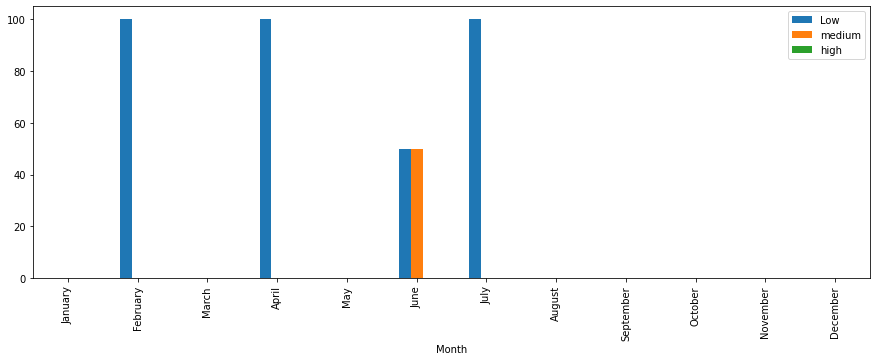

In [7]:
data_year(data1,'WOLF, BRIAN R',2020,'IN-PATIENT')

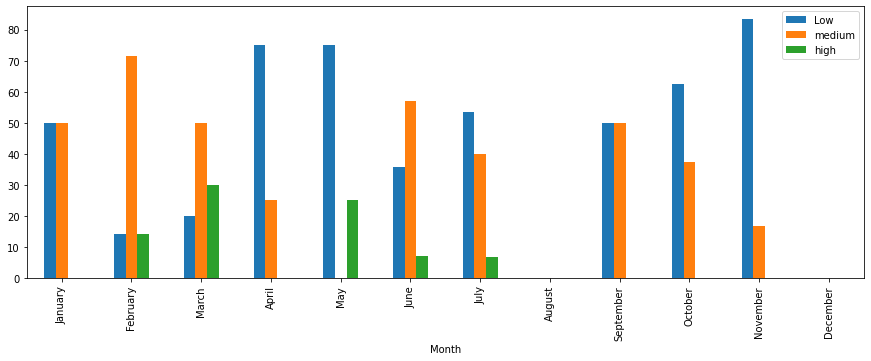

In [8]:
data_year(data1,'PATTERSON, BRENDAN M',2020,'IN-PATIENT')

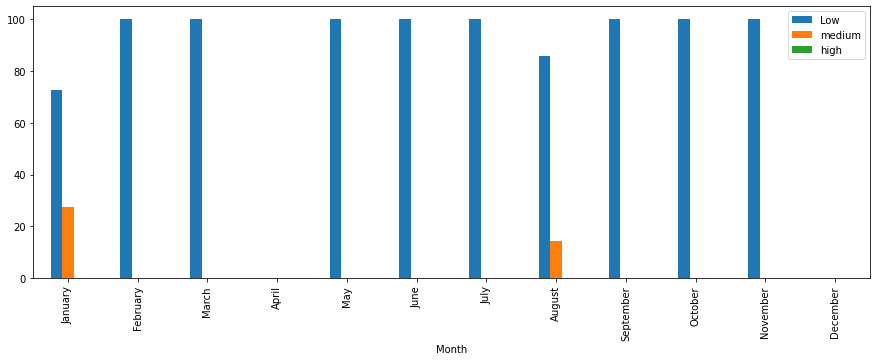

In [9]:
data_year(data1,'PATTERSON, BRENDAN M',2020,'OUT PATIENT')